# import data

In [49]:
import platform
import pandas as pd
from datetime import datetime, timedelta, time
ohlcv_data = pd.read_pickle('/Users/bokie/code/python/CMS/可转债套利/cms/stock_data_min_new.pkl')
print(ohlcv_data.keys())
for k,v in ohlcv_data.items():
    print(k,' data length: ',len(v))
print('数据起始日期',v.index[0])
print('数据结束日期',v.index[-1])
print('113642.SH数据起始日期',ohlcv_data['113642.SH'].index[0])
print('113642.SH数据结束日期',ohlcv_data['113642.SH'].index[-1])

dict_keys(['123046.SZ', '300587.SZ', '113642.SH', '603185.SH', '110061.SH', '600674.SH', '128081.SZ', '002203.SZ'])
123046.SZ  data length:  31460
300587.SZ  data length:  31460
113642.SH  data length:  13552
603185.SH  data length:  31460
110061.SH  data length:  31460
600674.SH  data length:  31460
128081.SZ  data length:  31460
002203.SZ  data length:  31460
数据起始日期 2021-12-13 09:30:00
数据结束日期 2022-06-28 15:00:00
113642.SH数据起始日期 2022-04-06 09:30:00
113642.SH数据结束日期 2022-06-28 15:00:00


# bond-stock pair

In [50]:
# cbond_pair = ['128081.SZ','002203.SZ']
# part = 1
# convert_price = 9.69
# stock_volume = 100/convert_price #整个回测期间不变


# cbond_pair = ['123046.SZ','300587.SZ']
# part = 1 
# convert_price = 6.73
# stock_volume = 100/convert_price  # 2021-12-13至2022-03-22   # 等于可转债的前收盘价/股票的前收盘价
# part = 2
# convert_price = 6.74
# stock_volume = 100/convert_price  # 2022-03-23至2022-06-28


# cbond_pair = ['110061.SH','600674.SH']
# part = 1
# convert_price = 9.2
# stock_volume = 100/convert_price #整个回测期间不变


cbond_pair = ['113642.SH','603185.SH']
# part = 1
# convert_price = 145.66
# stock_volume = 100/convert_price  # 2022-04-06至2022-06-01
part = 2
convert_price = 102.61
# stock_volume = 100/convert_price  # 2022-06-02至2022-06-28


In [51]:
cbond_pair_price = pd.DataFrame([])
cbond_pair_price = pd.concat([ohlcv_data[cbond_pair[0]]['close'],ohlcv_data[cbond_pair[1]]['close']],axis=1)
cbond_pair_price.columns = cbond_pair
cbond_pair_price = cbond_pair_price.dropna()
if cbond_pair[0] == '128081.SZ' or cbond_pair[0] == '110061.SH':
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':]
elif cbond_pair[0] == '123046.SZ' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':'2022-03-22 15:00:00']
elif cbond_pair[0] == '123046.SZ' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-03-23 15:00:00':]
elif cbond_pair[0] == '113642.SH' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2022-04-07 15:00:00':'2022-06-01 15:00:00']
elif cbond_pair[0] == '113642.SH' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-06-02 15:00:00':]


In [52]:
cbond_pair_price.head()

,113642.SH,603185.SH
2022-06-02 15:00:00,137.99,116.65
2022-06-06 09:30:00,136.93,113.72
2022-06-06 09:31:00,136.96,113.23
2022-06-06 09:32:00,136.52,113.18
2022-06-06 09:33:00,136.36,112.81


In [53]:
cbond_pair_price.tail()

,113642.SH,603185.SH
2022-06-28 14:53:00,155.33,136.43
2022-06-28 14:54:00,155.00,136.34
2022-06-28 14:55:00,154.97,136.71
2022-06-28 14:56:00,154.64,136.98
2022-06-28 15:00:00,154.89,136.80


# signal calculate

In [54]:
cbond_return = pd.DataFrame([])

cbond_preclose = cbond_pair_price.iloc[0,0] # 初始时刻的bond前收盘价
stock_preclose = cbond_pair_price.iloc[0,1] # 初始时刻的stock前收盘价

for index,row in cbond_pair_price.iterrows():
    
    cbond_return.loc[index,cbond_pair[0]] = row[cbond_pair[0]]/cbond_preclose - 1 # 算日内的return
    cbond_return.loc[index,cbond_pair[1]] = row[cbond_pair[1]]/stock_preclose - 1

    if index.time()==time(15,0,0):  #算完日内return，迭代到今日价格的最后一个time bar的时候，将其设为前收盘价
        cbond_preclose = row[cbond_pair[0]]    # 日内return指标用 现价/昨日收盘价 计算
        stock_preclose = row[cbond_pair[1]]
        
# 检查df是否有空值
cbond_return.isnull().sum(axis=0)  # 按列统计
cbond_return.isnull().sum(axis=1) # 按行统计
cbond_return.isnull().sum(axis=1).sum() # 统计整张表

0

In [55]:
pd.set_option('display.max_rows', None)
cbond_return['diff'] = cbond_return[cbond_pair[0]] - cbond_return[cbond_pair[1]]

In [56]:
open_threshold = 0.005  # 0.005 ~ 0.01 ~ 0.015 间隔是0.001
close_threshold = 0 #  0 ~ 0.001 ~ 0.002 ~ 0.003

open_threshold = 0.023  # 0.005 ~ 0.01 ~ 0.015 间隔是0.001
close_threshold = 0 #  0 ~ 0.001 ~ 0.002 ~ 0.003

# 新增每日开仓数目记录
intraday_open_times = 0
max_open = 1

pos_open_flag = 0
neg_open_flag = 0
cbond_position = pd.DataFrame([])
cbond_position.index = cbond_return.index
for index,row in cbond_return.iterrows():

    if row['diff'] >= open_threshold and pos_open_flag==0 and neg_open_flag==0:
        if intraday_open_times < max_open:
            #diff落在A区间，且无仓位，正开
            pos_open_flag = 1
            neg_open_flag = 0
            cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
            cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
            intraday_open_times += 1
        else:
            pos_open_flag = 0
            neg_open_flag = 0
            cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
            cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] >= open_threshold and pos_open_flag==0 and neg_open_flag==1:
        if intraday_open_times < max_open:
            #diff落在A区间，且有负仓，平仓再正开
            pos_open_flag=1
            neg_open_flag=0
            cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
            cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
            print('reverse open +1')
            intraday_open_times += 1
        else:
            pos_open_flag = 0
            neg_open_flag = 0
            cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
            cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] >= open_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff落在A区间，且有正仓，keep
        pos_open_flag=1
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

    if row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff 落在B区间，且有正仓，keep
        pos_open_flag=1
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = -1*pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在B区间，且有负仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    elif row['diff'] > close_threshold and row['diff'] < open_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff 落在B区间，且无仓，keep
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    
    if row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff 落在C区间，且有正仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在C区间，且有负仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    elif row['diff'] >= -1*close_threshold and row['diff'] <= close_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff 落在C区间，且无仓位，keep
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = neg_open_flag
    
    if row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在D区间，且有负仓，keep
        pos_open_flag=0
        neg_open_flag=1
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag

    elif row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==1 and neg_open_flag==0:
        #diff 落在D区间，且有正仓，平仓
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag
    elif row['diff'] > -1*open_threshold and row['diff'] < -1*close_threshold and pos_open_flag==0 and neg_open_flag==0:
        #diff 落在D区间，且无仓位，keep
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

    if row['diff'] <= -1*open_threshold and pos_open_flag==0 and neg_open_flag==0:
        if intraday_open_times < max_open:
            #diff 落在E区间，且无仓位，反开
            pos_open_flag=0
            neg_open_flag=1
            cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
            cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
            intraday_open_times += 1
        else:
            pos_open_flag=0
            neg_open_flag=0
            cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
            cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
    elif row['diff'] <= -1*open_threshold and pos_open_flag==1 and neg_open_flag==0:
        if intraday_open_times < max_open:
            #diff 落在E区间，且有正仓，平仓反开
            pos_open_flag=0
            neg_open_flag=1
            cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
            cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
            intraday_open_times += 1
        else:
            pos_open_flag=0
            neg_open_flag=0
            cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
            cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag
    elif row['diff'] <= -1*open_threshold and pos_open_flag==0 and neg_open_flag==1:
        #diff 落在E区间，且有负仓，keep
        pos_open_flag=0
        neg_open_flag=1
        cbond_position.loc[index,cbond_pair[0]] = neg_open_flag
        cbond_position.loc[index,cbond_pair[1]] = -1*neg_open_flag

    if index.time()==time(15,0,0): # 每日收盘时必须平仓（时间止损信号）
        intraday_open_times = 0 # 下一天开盘前，把当日记录下来的开仓次数清零
        pos_open_flag=0
        neg_open_flag=0
        cbond_position.loc[index,cbond_pair[0]] = pos_open_flag
        cbond_position.loc[index,cbond_pair[1]] = pos_open_flag

In [57]:
df_signal = pd.concat([cbond_pair_price,cbond_return,cbond_position],axis=1)
df_signal.columns = ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
print('open threshold',open_threshold,'close threshold',close_threshold)
# df_signal.to_csv('tmp_signal.csv')
# df_signal

open threshold 0.023 close threshold 0


In [58]:
df_signal.head(10)

,bond_price,stock_price,bond_rtn,stock_rtn,diff,bond_pos,stock_pos
2022-06-02 15:00:00,137.99,116.65,0.000000,0.000000,0.000000,0.0,0.0
2022-06-06 09:30:00,136.93,113.72,-0.007682,-0.025118,0.017436,0.0,0.0
2022-06-06 09:31:00,136.96,113.23,-0.007464,-0.029318,0.021854,0.0,0.0
2022-06-06 09:32:00,136.52,113.18,-0.010653,-0.029747,0.019094,0.0,0.0
2022-06-06 09:33:00,136.36,112.81,-0.011812,-0.032919,0.021107,0.0,0.0
2022-06-06 09:34:00,136.70,112.58,-0.009349,-0.034891,0.025542,-1.0,1.0
2022-06-06 09:35:00,137.24,113.14,-0.005435,-0.030090,0.024655,-1.0,1.0
2022-06-06 09:36:00,137.10,113.57,-0.006450,-0.026404,0.019954,-1.0,1.0
2022-06-06 09:37:00,137.47,113.45,-0.003768,-0.027432,0.023664,-1.0,1.0
2022-06-06 09:38:00,137.50,113.76,-0.003551,-0.024775,0.021224,-1.0,1.0


In [59]:
# if df_signal.index[0].time() == time(15,0,0):
#     print(True)
#     stk_volume = df_signal['bond_price'][0]/df_signal['stock_price'][0]
# print(stk_volume)

# backtest

In [60]:
# 用来记录交易流水的表格,一边遍历df_signal，一边填入内容到流水表格里

import numpy as np
cols = ['balance','signal','bond price','stock price','bond hold','stock hold','commission','tax','reverse open','diff','asset value']
df_trade = pd.DataFrame(
    data = [[0,np.nan,np.nan,np.nan,0,0,0,0,np.nan,np.nan,0]],
    columns=cols
    ) 

balance_last = 0 # 现金账户初始余额

bond_hold = 0 # 债券持有数量
stock_hold = 0 # 股票持有数量

commission_rate = 2/10000 # 佣金买卖万二
tax_rate = 1/1000 # 卖股票才收印花税千一

# commission_rate = 0/10000 # 佣金买卖万二
# tax_rate = 0/1000 #

for i in range(len(df_signal)-1):
    if df_signal.index[i].time() == time(15,0,0):
        # 修改stock volume 每天固定一个stock volume 应该用债的前收盘价/股票的前收盘价
        stock_volume = df_signal['bond_price'][i]/df_signal['stock_price'][i]

    if df_signal.values[i][-1] != df_signal.values[i+1][-1]:
        index = df_signal.index[i+1]
        diff = df_signal.values[i+1][-3] #diff在df_signal中的倒数第三列
    # df_signal的columns
    # ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
        signal = str(int(df_signal.values[i+1][-2]))+str(int(df_signal.values[i+1][-1]))
        
        bond_price = df_signal.values[i+1][0] 

        stock_price = df_signal.values[i+1][1]

        # stock_volume =  bond_price/stock_price # 修改stock volume 每天固定一个stock volume应该用债的前收盘价/股票的前收盘价

        commission = (bond_price + stock_price * stock_volume) * commission_rate

        reverse_open = False #表明这笔交易，是否包含平仓后再反向开仓的操作

        if signal == '00' and stock_hold == stock_volume: #有股票持仓并且需要卖出平仓时，有印花税
            tax = stock_price * tax_rate * stock_volume
        else:
            tax = 0

        if signal == '00':
            balance_last += bond_hold*bond_price
            balance_last += stock_hold*stock_price
            
            bond_hold = 0
            stock_hold = 0
            

        if signal == '1-1':
            '''
            加一个检测之前持仓的模块,如果之前因为-11的信号有持仓,需要先平掉(即买债卖股票),同时再反向开仓
            '''
            reverse_flag = False
            if bond_hold == -1 and stock_hold == 1*stock_volume:
                bond_hold = 0
                stock_hold = 0
                balance_last -= bond_price 
                balance_last += stock_price * stock_volume
                commission *= 2 # 因为平掉之后再反向开仓，手续费double
                tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税
                reverse_flag = True
                reverse_open = True

            bond_hold += 1
            stock_hold += (-1 * stock_volume)
            # stock_hold += stock_volume
            balance_last -= bond_price
            balance_last += stock_price * stock_volume
            
            if reverse_flag:
                tax *= 2 #平仓然后反向开仓的时候 已经计算过tax了，直接double
            else:
                tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税

        if signal == '-11':
            '''
            加一个检测之前持仓的模块,如果之前因为1-1的信号有持仓,需要先平掉(卖债买股票),同时再反向开仓
            '''
            if bond_hold == 1 and stock_hold == -1*stock_volume:
                bond_hold = 0
                stock_hold = 0
                balance_last += bond_price
                balance_last -= stock_price * stock_volume
                commission *= 2 # 因为平掉之后再反向开仓，手续费double
                                # 买股票无印花税
                reverse_open = True
            bond_hold += -1
            stock_hold += (1 * stock_volume)
            # stock_hold += stock_volume
            balance_last += bond_price
            balance_last -= stock_price * stock_volume
        
        balance_last = balance_last - commission - tax
        balance = balance_last
        asset_value = bond_price*bond_hold + stock_price*stock_hold
        line = [balance,signal,bond_price,stock_price,bond_hold,stock_hold,commission,tax,reverse_open,diff,asset_value]
        # df_trade.loc[index,['balance','asset','signal','bond price','stock price','commission','tax']] = line
        # df_trade.loc[index,cols] = [0,0,np.nan,np.nan,np.nan,0,0,0,0]
        df_trade.loc[index,cols] = line

df_trade.rename(columns={'balance':'cash'},inplace=True)       


In [61]:
# df_trade.to_excel('tmp_trade.xlsx')
# df_trade[df_trade['signal']=='00']
# df_trade['net value'] = df_trade['balance'] + df_trade['asset value']
df_trade['net value'] = df_trade['cash'] + df_trade['asset value']

# df_trade

In [62]:
# 错误的净值算法
# df_trade['net value'] = df_trade['balance'] + \
#                         df_trade['bond price']*df_trade['bond hold'] + \
#                         df_trade['stock price']*df_trade['stock hold'] - \
#                         df_trade['commission'] - \
#                         df_trade['tax']

In [63]:
# nv = []
# tmp_nv = 0


In [64]:
#把交易序列单个时间节点的扩展到整个序列
# assert False
df_nv = df_trade[['net value']].iloc[1:]
df_nv['time'] = df_nv.index
df_tmp = df_signal[['diff']]
df_tmp['time'] = df_tmp.index
#  merge之后再前向往后fillna
df_nv_full =  pd.merge(df_nv,df_tmp,how='outer').sort_values(by='time').fillna(method='ffill').fillna(0)
df_nv_full.index = df_tmp.index
df_nv_full = df_nv_full[['net value']]


/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_5341/788458400.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

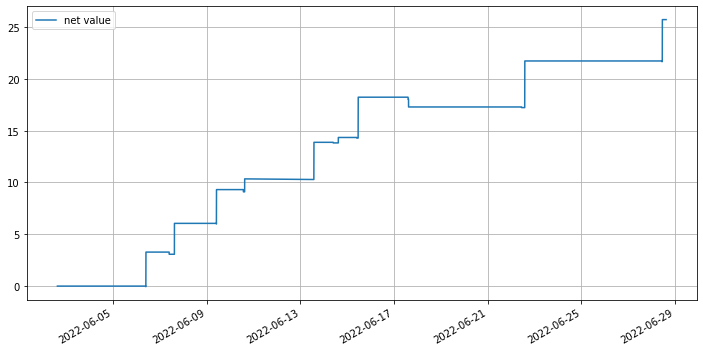

In [65]:
df_nv_full.plot(figsize=(12,6),grid=True,)

# statistic & analysis

In [66]:
df_trade_2 = df_trade.copy(deep=True)
df_trade_2 = df_trade_2.iloc[1:,:] #删掉df_trade原来构建时带有的空行
rounds = [] #只包含单个来回，每2条交易记录组成一个来回的组
reverse_rounds = [] # 包含多个来回，信号之间包含平仓同时反向开仓的组
# for i in range(len(df_trade)-1,0,-1):
for i in range(len(df_trade)-1,-1,-1):
    if df_trade_2.iloc[i-1,:]['signal'] == '00':
        round = df_trade_2.iloc[i:,:]
        if len(round)>2:
            reverse_rounds.append(round)
        elif len(round)==2:
            rounds.append(round)
        df_trade_2 = df_trade_2.iloc[:i]

In [67]:
#检查切片是否完全
clips_length = 0
for tmp_round in rounds:
    clips_length += len(tmp_round)
for tmp_round in reverse_rounds:
    clips_length += len(tmp_round)
print(clips_length,len(df_trade))

20 21


In [68]:
num_round = len(rounds)
for i in reverse_rounds:
    num_round += len(i)-1
print('single round:',num_round)
print('reverse rounds: ',len(reverse_rounds))

single round: 10
reverse rounds:  0


# normal round stat

In [69]:
return_in_rounds = []
tmp_lose_round= []
win = 0
lose = 0
win_profit = 0
lose_profit = 0
for i in rounds:
    
    tmp_profit = (i['net value'] - i['net value'].shift(1)).values[-1] - i['commission'].values[0] - i['tax'].values[0] # 修正单个normal round的 profit计算方式
    single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
    
    return_in_round = tmp_profit/single_round_cost
    return_in_rounds.append(return_in_round)
    
    
    if tmp_profit>0:
        win += 1
        win_profit += tmp_profit
    else:
        tmp_lose_round.append(i)
        lose += 1
        lose_profit += tmp_profit
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print(len(return_in_rounds))

win:  9
lose:  1
win profit:  26.66449692904516
lose profit:  -0.9434714708520713
10


In [70]:
print('len of rounds',len(rounds))
print('len of df_trade',len(df_trade))
tmp_sum = 0
for i in range(len(rounds)-11,):
    tmp_sum += (rounds[i]['net value'].values[1] - rounds[i-1]['net value'].values[1])
print(df_trade['net value'].values[-1])
print(tmp_sum)

len of rounds 10
len of df_trade 21
25.721025458193054
0


# find close by signal lose round

In [71]:
print('len of tmp_lose_round: ',len(tmp_lose_round)) #这是normal round里lose的，包含了close by signal lose 和close by time lose
for i in range(len(tmp_lose_round)-1):
    tmp_round = tmp_lose_round[i]
    if tmp_round.index[-1].time() != time(15,0,0):
        # 找出close by signal lose
        print(i)
# tmp_lose_round[31]

len of tmp_lose_round:  1


In [72]:
# tmp_lose_round[6]

In [73]:
open_threshold,close_threshold

(0.023, 0)

In [74]:
# df_signal.loc['2022-01-25'].tail()

In [75]:
df_trade

,cash,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,diff,asset value,net value
0,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000
2022-06-06 09:34:00,3.470592,-11,136.70,112.58,-1.0,1.182940,0.053975,0.000000,False,2.554220e-02,-3.524568,-0.053975
2022-06-06 09:42:00,3.282787,00,138.15,116.79,0.0,0.000000,0.055261,0.138156,False,-4.066714e-05,0.000000,3.282787
2022-06-07 09:32:00,7.058673,1-1,145.79,128.09,1.0,-1.169293,0.059113,0.149775,False,-2.768357e-02,-3.984773,3.073900
2022-06-07 15:00:00,6.054469,00,142.42,122.61,0.0,0.000000,0.057157,0.000000,False,-6.579452e-03,0.000000,6.054469
2022-06-09 09:58:00,9.520718,-11,152.05,126.98,-1.0,1.169662,0.060115,0.000000,False,2.440390e-02,-3.526364,5.994355
2022-06-09 10:01:00,9.313927,00,147.81,126.37,0.0,0.000000,0.059124,0.147810,False,-9.859099e-07,0.000000,9.313927
2022-06-10 13:37:00,12.855025,1-1,150.27,133.72,1.0,-1.151854,0.060859,0.154026,False,-2.589798e-02,-3.755984,9.099042
2022-06-10 15:00:00,10.348513,00,150.29,132.60,0.0,0.000000,0.060605,0.000000,False,-1.686483e-02,0.000000,10.348513
2022-06-13 09:30:00,13.769912,-11,151.89,130.94,-1.0,1.133409,0.060060,0.000000,False,2.316494e-02,-3.481459,10.288454


# reverse round stat

In [76]:
''' 
先把连续反向开仓的信号拆开
e.g.  1-1 -11 00 ---> 1-1 00 -11 00
'''

reverse_rounds_reconstruct = []
for reverse_round in reverse_rounds:
    reverse_rounds0_reconstruct = []
    for i in range(0,len(reverse_round)-1): #4-2

        # tmp_cols = reverse_rounds[0].columns
        # tmp_index = reverse_rounds[0].iloc[i,:].reset_index()
        m = reverse_round.iloc[i,:].tolist()
        n = reverse_round.iloc[i+1,:].tolist()
        # reverse_rounds0_reconstruct.append(m)
        tmp_balance = m[0] + n[2]*m[4] + n[3]*m[5] 
        tmp_commission = n[6]/2
        tmp_tax = n[7]/2
        tmp_nv =  tmp_balance - tmp_commission - tmp_tax
        
        insert_line  = [tmp_balance,'00',np.nan,np.nan,0,0,tmp_commission,tmp_tax,'-',tmp_nv]
        reverse_rounds0_reconstruct.append(m)
        reverse_rounds0_reconstruct.append(insert_line)
    # reverse_rounds0_reconstruct.append(n)    
    tmp_cols = reverse_round.columns
    reverse_rounds0_reconstruct[-1] = reverse_round.iloc[-1,:].tolist()
    tmp_round = pd.DataFrame(reverse_rounds0_reconstruct[:],columns=tmp_cols)
    tmp_round
    for index,row in tmp_round.iterrows():
        if row['reverse open'] == True:
            tmp_round.loc[index,['commission','tax']] = tmp_round.loc[index,['commission','tax']]/2
    tmp_round = tmp_round.fillna(method = 'bfill')
    
    # new nv 这列中只有拆出来的虚拟平仓单的数目是正确的，其他都是错误的，把正确的值赋到net value原来的位置上后，这一列就废弃了
    # tmp_round['new nv'] = tmp_round['balance'] + tmp_round['bond price']*tmp_round['bond hold'] + tmp_round['stock price']*tmp_round['stock hold'] - tmp_round['commission'] - tmp_round['tax']
    
    # tmp_round的columns
    # ['balance', 'signal', 'bond price', 'stock price', 'bond hold',
    #        'stock hold', 'commission', 'tax', 'reverse open', 'diff',
    #        'asset value', 'net value']
    for i in range(len(tmp_round)-2): #把拆分出来的虚拟平仓的balance赋值为nv，因为没持仓时，cash应该要等于nv
        if tmp_round.iloc[i,:]['signal'] == '00':

            tmp_round_new_nv = tmp_round.iloc[i,:]['cash'] + tmp_round.iloc[i,:]['bond price']*tmp_round.iloc[i,:]['bond hold'] + \
                tmp_round.iloc[i,:]['stock price']*tmp_round.iloc[i,:]['stock hold'] - tmp_round.iloc[i,:]['commission'] - tmp_round.iloc[i,:]['tax']

            tmp_round.iloc[i,11] = tmp_round_new_nv #  net value赋值为new nv  拆出来的虚拟平仓单计算出来的新值
            tmp_round.iloc[i,0] = tmp_round_new_nv #balance赋值为new nv
            tmp_round.iloc[i,9] = tmp_round.iloc[i+1,9] # diff要等于下一行的diff
            tmp_round.iloc[i,10] = 0 # asset_value要等于0
            


    reverse_rounds_reconstruct.append(tmp_round)

reverse_rounds_detail = []
for reverse_round in reverse_rounds_reconstruct:
    # print(len(reverse_round))
    for i in range(0,len(reverse_round)-1,2):
        df_tmp = reverse_round.iloc[i:i+2,:]
        reverse_rounds_detail.append(df_tmp)
print('len of reverse_rounds_detail : ',len(reverse_rounds_detail))
##########################################################################################################################################
# return_in_rounds = []
# win = 0
# lose = 0
# win_profit = 0
# lose_profit = 0
for i in reverse_rounds_detail:
    
    # tmp_profit = (i['new nv'] - i['new nv'].shift(1)).values[-1]
    tmp_profit = (i['net value'] - i['net value'].shift(1)).values[-1] - i['commission'].values[0] - i['tax'].values[0] # 修正单个reverse rounds detail的 profit计算方式
    single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
    
    return_in_round = tmp_profit/single_round_cost
    return_in_rounds.append(return_in_round)
    
    
    if tmp_profit>0:
        win += 1
        win_profit += tmp_profit
    else:
        lose += 1
        lose_profit += tmp_profit
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print(len(return_in_rounds))

len of reverse_rounds_detail :  0
win:  9
lose:  1
win profit:  26.66449692904516
lose profit:  -0.9434714708520713
10


In [77]:
reverse_rounds_detail

[]

# close by time&signal stat

In [78]:
# 对normal round 进行统计
close_by_time = 0
close_by_time_win = 0
close_by_time_lose = 0

close_by_signal = 0
close_by_signal_win = 0
close_by_signal_lose = 0

for tmp_round in rounds:
    tmp_profit = tmp_round['net value'].tolist()[1] - tmp_round['net value'].tolist()[0] - tmp_round['commission'].values[0] - tmp_round['tax'].values[0] # 修正单个normal round的 profit计算方式
    if tmp_round.index[1].time() == time(15,0,0):
        close_by_time += 1
        if tmp_profit > 0:
            close_by_time_win += 1
        else:
            close_by_time_lose += 1
    else:
        close_by_signal += 1
        if tmp_profit > 0:
            close_by_signal_win += 1
        else:
            close_by_signal_lose += 1
            print(tmp_round)

print('close_by_time: ',close_by_time)
print('close_by_time_win: ',close_by_time_win)
print('close_by_time_lose: ',close_by_time_lose)
print()
print('close_by_signal: ',close_by_signal)
print('close_by_signal_win: ',close_by_signal_win)
print('close_by_signal_lose: ',close_by_signal_lose)
print(close_by_time+close_by_signal)


close_by_time:  4
close_by_time_win:  3
close_by_time_lose:  1

close_by_signal:  6
close_by_signal_win:  6
close_by_signal_lose:  0
10


In [79]:

# 对reverse round 进行统计
for tmp_round in reverse_rounds_detail: #统计reverse_rounds_detail的时候，所有round都当做是close by signal的
    # tmp_profit = tmp_round['new nv'].tolist()[1] - tmp_round['new nv'].tolist()[0]  
    tmp_profit = tmp_round['net value'].tolist()[1] - tmp_round['net value'].tolist()[0] - tmp_round['commission'].values[0] - tmp_round['tax'].values[0] # 修正单个reverse rounds detail的 profit计算方式
    close_by_signal += 1
    if tmp_profit > 0:
        close_by_signal_win += 1
    else:
        close_by_signal_lose += 1
        # print(tmp_round)

if len(reverse_rounds) == 1:  #解决只有1个元素时，for循环范围失效的bug
    if reverse_rounds[0].index[-1].time()==time(15,0,0):
        close_by_time += 1
        close_by_signal -= 1
        # tmp_profit = reverse_rounds_reconstruct[i]['new nv'].tolist()[-1] - reverse_rounds_reconstruct[i]['new nv'].tolist()[-2]
        # 修正单个reverse rounds detail的 profit计算方式
        tmp_profit = reverse_rounds_reconstruct[0]['net value'].tolist()[-1] - reverse_rounds_reconstruct[0]['net value'].tolist()[-2]\
                    - reverse_rounds_reconstruct[0]['commission'].values[0] - reverse_rounds_reconstruct[0]['tax'].values[0]
             
                    
        if tmp_profit > 0:
            close_by_time_win += 1
            close_by_signal_win -= 1
        else:
            close_by_time_lose += 1
            close_by_signal_lose -= 1      
            # print(reverse_rounds[0])
else:
    for i in range(len(reverse_rounds)-1):
        if reverse_rounds[i].index[-1].time()==time(15,0,0):
            close_by_time += 1
            close_by_signal -= 1
            # tmp_profit = reverse_rounds_reconstruct[i]['new nv'].tolist()[-1] - reverse_rounds_reconstruct[i]['new nv'].tolist()[-2]
            # 修正单个reverse rounds detail的 profit计算方式
            tmp_profit = reverse_rounds_reconstruct[i]['net value'].tolist()[-1] - reverse_rounds_reconstruct[i]['net value'].tolist()[-2]\
                        - reverse_rounds_reconstruct[i]['commission'].values[0] - reverse_rounds_reconstruct[i]['tax'].values[0]
            if tmp_profit > 0:
                close_by_time_win += 1
                close_by_signal_win -= 1
            else:
                close_by_time_lose += 1
                close_by_signal_lose -= 1      
                # print(reverse_rounds[i])
print('close_by_time: ',close_by_time)
print('close_by_time_win: ',close_by_time_win)
print('close_by_time_lose: ',close_by_time_lose)
print()
print('close_by_signal: ',close_by_signal)
print('close_by_signal_win: ',close_by_signal_win)
print('close_by_signal_lose: ',close_by_signal_lose)
print(close_by_time+close_by_signal)  

close_by_time:  4
close_by_time_win:  3
close_by_time_lose:  1

close_by_signal:  6
close_by_signal_win:  6
close_by_signal_lose:  0
10


# final performance

In [80]:
win_rate = win/(win+lose)
win_profit_avg = win_profit/win
if lose == 0:
    lose_profit_avg = 0
else:
    lose_profit_avg = lose_profit/lose
if lose_profit_avg == 0:
    profit_ratio = float('inf')
else:
    profit_ratio = win_profit_avg/abs(lose_profit_avg)

total_round = win + lose 

trade_days = len(df_nv_full.resample('D').last().dropna()) -1 
round_per_day = total_round/trade_days
return_per_round = sum(return_in_rounds)/len(return_in_rounds)
print('$'*50)
print('pair code:',cbond_pair)
print('convert price: ',convert_price)
print('first trade time',df_trade.index[1])
print('last trade time',df_trade.index[-1])
print('$'*50)
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print('sum of win&lose profit: ',win_profit+lose_profit)
print('final net value:',df_trade['net value'].values[-1])
print('win rate: ', win_rate)
print('profit ratio: ',profit_ratio)
print('trade days: ',trade_days)
print('total round: ',total_round)
print('avg round in a day: ',round_per_day)
print('return_per_round: ',return_per_round)

print('close_by_time: ',close_by_time)
print('close_by_time_win: ',close_by_time_win)
print('close_by_time_loss: ',close_by_time_lose)
print('close_by_signal: ',close_by_signal)
print('close_by_signal_win: ',close_by_signal_win)
print('close_by_signal_loss: ',close_by_signal_lose)
print('@'*80)


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
pair code: ['113642.SH', '603185.SH']
convert price:  102.61
first trade time 2022-06-06 09:34:00
last trade time 2022-06-28 11:04:00
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
win:  9
lose:  1
win profit:  26.66449692904516
lose profit:  -0.9434714708520713
sum of win&lose profit:  25.72102545819309
final net value: 25.721025458193054
win rate:  0.9
profit ratio:  3.1402347315593064
trade days:  17
total round:  10
avg round in a day:  0.5882352941176471
return_per_round:  0.01784034493117695
close_by_time:  4
close_by_time_win:  3
close_by_time_loss:  1
close_by_signal:  6
close_by_signal_win:  6
close_by_signal_loss:  0
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [81]:
df_res = pd.DataFrame(data = [[np.nan]*20],
    columns=['cbond pair','convert price','win','lose','win profit','lose profit',
    'sum of win&lose profit','final net value','win rate',
    'profit ratio','trade days','total round','avg round in a day','return per round',
    'close by time','close by time win','close by time lose',
    'close by signal','close by signal win','close by signal lose'])

tmp_idx = str(df_trade.index[1]) + ' -> ' + str(df_trade.index[-1])
tmp_line = [cbond_pair,convert_price,win,lose,win_profit,lose_profit,
            win_profit+lose_profit,df_trade['net value'].values[-1],win_rate,
            profit_ratio,trade_days,total_round,round_per_day,return_per_round,
            close_by_time,close_by_time_win,close_by_time_lose,
            close_by_signal,close_by_signal_win,close_by_signal_lose]

df_res.loc[tmp_idx,df_res.columns] = tmp_line
df_res = df_res.dropna()
df_res['open threshold'] = open_threshold
df_res['close threshold'] = close_threshold
df_res[['win','lose','total round','close by time','close by time win','close by time lose','close by signal','close by signal win','close by signal lose','open threshold','close threshold','win rate']]

/Users/bokie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,win,lose,total round,close by time,close by time win,close by time lose,close by signal,close by signal win,close by signal lose,open threshold,close threshold,win rate
2022-06-06 09:34:00 -> 2022-06-28 11:04:00,9.0,1.0,10.0,4.0,3.0,1.0,6.0,6.0,0.0,0.023,0,0.9


In [82]:
pd.set_option('display.max_columns', None)
df_res

,cbond pair,convert price,win,lose,win profit,lose profit,sum of win&lose profit,final net value,win rate,profit ratio,trade days,total round,avg round in a day,return per round,close by time,close by time win,close by time lose,close by signal,close by signal win,close by signal lose,open threshold,close threshold
2022-06-06 09:34:00 -> 2022-06-28 11:04:00,"[113642.SH, 603185.SH]",102.61,9.0,1.0,26.664497,-0.943471,25.721025,25.721025,0.9,3.140235,17.0,10.0,0.588235,0.01784,4.0,3.0,1.0,6.0,6.0,0.0,0.023,0


In [83]:
df_trade[['signal','diff','net value']].to_excel('tmp_trade.xlsx')

In [84]:
df_res['trade days']

2022-06-06 09:34:00 -> 2022-06-28 11:04:00    17.0
Name: trade days, dtype: float64

In [85]:
# -11
# 1-1
# 固定的stock volume 
# 等于可转债的前收盘价/股票的前收盘价

In [86]:
# df_trade

In [87]:
df_signal

,bond_price,stock_price,bond_rtn,stock_rtn,diff,bond_pos,stock_pos
2022-06-02 15:00:00,137.99,116.65,0.000000,0.000000,0.000000e+00,0.0,0.0
2022-06-06 09:30:00,136.93,113.72,-0.007682,-0.025118,1.743616e-02,0.0,0.0
2022-06-06 09:31:00,136.96,113.23,-0.007464,-0.029318,2.185417e-02,0.0,0.0
2022-06-06 09:32:00,136.52,113.18,-0.010653,-0.029747,1.909416e-02,0.0,0.0
2022-06-06 09:33:00,136.36,112.81,-0.011812,-0.032919,2.110654e-02,0.0,0.0
2022-06-06 09:34:00,136.70,112.58,-0.009349,-0.034891,2.554220e-02,-1.0,1.0
2022-06-06 09:35:00,137.24,113.14,-0.005435,-0.030090,2.465484e-02,-1.0,1.0
2022-06-06 09:36:00,137.10,113.57,-0.006450,-0.026404,1.995403e-02,-1.0,1.0
2022-06-06 09:37:00,137.47,113.45,-0.003768,-0.027432,2.366410e-02,-1.0,1.0
2022-06-06 09:38:00,137.50,113.76,-0.003551,-0.024775,2.122399e-02,-1.0,1.0


# signal analysis

In [88]:
# plot pair moving trend: diff = cbond reutrn - stock return 
cbond_return['diff'] = cbond_return[cbond_pair[0]] - cbond_return[cbond_pair[1]]

from turtle import title
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter(name=cbond_pair[0], x=cbond_return.index, y=cbond_return[cbond_pair[0]]),
    go.Scatter(name=cbond_pair[1], x=cbond_return.index, y=cbond_return[cbond_pair[1]]),
    go.Scatter(name='diff', x=cbond_return.index, y=cbond_return['diff']),
])
fig.show()

    
# test stationary
from statsmodels.tsa.stattools import adfuller
if adfuller(cbond_return['diff'])[1] < 0.001:
    print("This cbond-stock pair is stationary!")
else:
    print("This cbond-stock pair is not stationary!")

This cbond-stock pair is stationary!


# output to excel

In [89]:
# df_performance = pd.read_excel('performance_2.xlsx',index_col=0)
# df_performance = df_performance.append(df_res)
# df_performance.to_excel('performance_2.xlsx')

In [90]:
print('open threshold: ',open_threshold,'close threshold: ',close_threshold)
# df_trade.rename(columns={'balance':'cash'},inplace=True)
# df_trade.to_excel('tmp_open0.005-close0.xlsx')
df_trade

open threshold:  0.023 close threshold:  0


,cash,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,diff,asset value,net value
0,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000
2022-06-06 09:34:00,3.470592,-11,136.70,112.58,-1.0,1.182940,0.053975,0.000000,False,2.554220e-02,-3.524568,-0.053975
2022-06-06 09:42:00,3.282787,00,138.15,116.79,0.0,0.000000,0.055261,0.138156,False,-4.066714e-05,0.000000,3.282787
2022-06-07 09:32:00,7.058673,1-1,145.79,128.09,1.0,-1.169293,0.059113,0.149775,False,-2.768357e-02,-3.984773,3.073900
2022-06-07 15:00:00,6.054469,00,142.42,122.61,0.0,0.000000,0.057157,0.000000,False,-6.579452e-03,0.000000,6.054469
2022-06-09 09:58:00,9.520718,-11,152.05,126.98,-1.0,1.169662,0.060115,0.000000,False,2.440390e-02,-3.526364,5.994355
2022-06-09 10:01:00,9.313927,00,147.81,126.37,0.0,0.000000,0.059124,0.147810,False,-9.859099e-07,0.000000,9.313927
2022-06-10 13:37:00,12.855025,1-1,150.27,133.72,1.0,-1.151854,0.060859,0.154026,False,-2.589798e-02,-3.755984,9.099042
2022-06-10 15:00:00,10.348513,00,150.29,132.60,0.0,0.000000,0.060605,0.000000,False,-1.686483e-02,0.000000,10.348513
2022-06-13 09:30:00,13.769912,-11,151.89,130.94,-1.0,1.133409,0.060060,0.000000,False,2.316494e-02,-3.481459,10.288454


# signal analysis 2

In [91]:
# import plotly.graph_objects as go
 
# tmp_df_signal = df_signal.loc['2022-03-21',:]
# fig = go.Figure(data=[
#     # go.Scatter(name=cbond_pair[0], x=cbond_return.index, y=cbond_return[cbond_pair[0]]),
#     # go.Scatter(name=cbond_pair[1], x=cbond_return.index, y=cbond_return[cbond_pair[1]]),
#     go.Scatter(name='diff', x=tmp_df_signal.index, y=tmp_df_signal['diff']),
# ])
# fig.show()


In [92]:
# 所有收盘时刻 diff的分布
import plotly.express as px

tmp_df_signal_close = df_signal[df_signal.index.time==time(15,0,0)]
fig = px.scatter(tmp_df_signal_close.reset_index(),x='index', y='diff',
                # marginal_x="histogram",
                # text=tmp_grid_res['scatter label'].tolist()
                )
fig.show()

In [93]:
cbond_pair,part


(['113642.SH', '603185.SH'], 2)

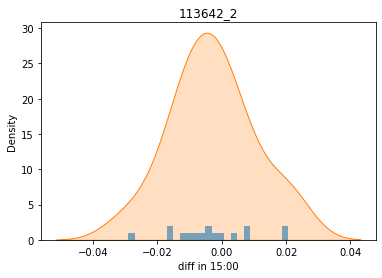

In [94]:
# 所有收盘时刻 diff的分布
from turtle import title
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
fig,ax=plt.subplots()

tmp_title = cbond_pair[0].split('.')[0]+'_'+str(part)
ax.set_title(tmp_title)
ax.set_xlabel('diff in 15:00')
tmp_data = tmp_df_signal_close['diff'].tolist()

ax.hist(tmp_data,bins=25,histtype="stepfilled",alpha=0.6)

sns.kdeplot(tmp_data,shade=True)

plt.show()

In [95]:
# win rate 
# return per round
# 网格搜索，优化参数，目标是总盈利
# 加上每日开平仓次数限制 只能1次
# 后面每周用的参数应该是 根据过去4周的数据优化过的

In [96]:
df_trade

,cash,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,diff,asset value,net value
0,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000
2022-06-06 09:34:00,3.470592,-11,136.70,112.58,-1.0,1.182940,0.053975,0.000000,False,2.554220e-02,-3.524568,-0.053975
2022-06-06 09:42:00,3.282787,00,138.15,116.79,0.0,0.000000,0.055261,0.138156,False,-4.066714e-05,0.000000,3.282787
2022-06-07 09:32:00,7.058673,1-1,145.79,128.09,1.0,-1.169293,0.059113,0.149775,False,-2.768357e-02,-3.984773,3.073900
2022-06-07 15:00:00,6.054469,00,142.42,122.61,0.0,0.000000,0.057157,0.000000,False,-6.579452e-03,0.000000,6.054469
2022-06-09 09:58:00,9.520718,-11,152.05,126.98,-1.0,1.169662,0.060115,0.000000,False,2.440390e-02,-3.526364,5.994355
2022-06-09 10:01:00,9.313927,00,147.81,126.37,0.0,0.000000,0.059124,0.147810,False,-9.859099e-07,0.000000,9.313927
2022-06-10 13:37:00,12.855025,1-1,150.27,133.72,1.0,-1.151854,0.060859,0.154026,False,-2.589798e-02,-3.755984,9.099042
2022-06-10 15:00:00,10.348513,00,150.29,132.60,0.0,0.000000,0.060605,0.000000,False,-1.686483e-02,0.000000,10.348513
2022-06-13 09:30:00,13.769912,-11,151.89,130.94,-1.0,1.133409,0.060060,0.000000,False,2.316494e-02,-3.481459,10.288454
